[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/stan/jet/notebooks/DLN_SGLD_trajectory_notebook.ipynb)

# Normal Crossing SGLD trajectory notebook

This notebook uses SGLD to sample from the posterior around a point, for a polynomial model characterized by $y_{pred} = w_1^a * w_2^b * x$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned and $x$ is our (1-dimensional) input.

Both the input $x$ and target data $y$ are generated using (independent) gaussian noise, and the loss is Mean Squared Error from $y$ to $y_{pred}$, so the model achieves its lowest loss when $w_1=0$ or $w_2=0$.


In [1]:
# !pip uninstall devinterp -y
# %cd ..
# !pip install -e .
# !pip install git+https://github.com/timaeus-research/devinterp.git@stan/jet

%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# @title
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib.colors import LinearSegmentedColormap

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.llc import OnlineLLCEstimator
from devinterp.utils import default_nbeta, evaluate_mse
from devinterp.slt.sampler import sample

from devinterp.jet_tools.plot import *
from devinterp.jet_tools.models import *
from devinterp.jet_tools.diffs import *
from devinterp.jet_tools.utils import *

# **Auxiliary functions**

In [3]:
# plotting
sns.set_style("whitegrid")

# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4))


lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple(
    [x + (1 - x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.0]
)

colors = [SECONDARY, lighter_SECONDARY]
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
SEED = 0
SIGMA = 1
NUM_TRAIN_SAMPLES = 1000
BATCH_SIZE = NUM_TRAIN_SAMPLES
EVALUATE = evaluate_mse

train_loader, train_data, x, y = generate_dataset_for_seed(
    seed=SEED, sigma=SIGMA, batch_size=BATCH_SIZE, num_samples=NUM_TRAIN_SAMPLES
)

# **SGLD trajectories sampling**


In [6]:
method = "xavier"
dln_model = DLN(
    DLNConfig(
        input_dim=2,
        hidden_dim=2,
        output_dim=2,
        n_layers=2,
        initialization_method=method,  # "xavier" "zeros" "random" "kaiming"
    )
)

dln_dataset = create_dataset(dln_model, seed=SEED)
dln_dataloader = torch.utils.data.DataLoader(dln_dataset, batch_size=64)

Created continuous dataset (shuffle parameter is ignored)


In [7]:
INITIAL_PARAMETERS = [0.0, 0.0]
A_B = [
    1,
    3,
]  # MSE loss function and zero-mean gaussian, so this is effectively w_1**2 * w_2**4 as loss, NB

nbeta = default_nbeta(len(train_data))  # = n/log(n)
model = PolyModel(torch.tensor(A_B).to(DEVICE), DEVICE).to(
    DEVICE
)  # lol idk which one it should be
model.weights = nn.Parameter(
    torch.tensor(INITIAL_PARAMETERS, dtype=torch.float32, requires_grad=True).to(DEVICE)
)

In [8]:
sampling_method = SGLD

# Number and length of chains
num_chains_sgld = 1
num_draws_sgld = 10_0

# SGLD parameters
epsilon_sgld = 0.005

In [9]:
torch.manual_seed(SEED)
np.random.seed(SEED)
weights = WeightCallback(
    num_chains=num_chains_sgld, num_draws=num_draws_sgld, model=dln_model
)

online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgld,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)
trace_sgld = sample(
    dln_model,
    dln_dataloader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(lr=epsilon_sgld, nbeta=nbeta, bounding_box_size=1.0),
    sampling_method=sampling_method,
    num_chains=num_chains_sgld,  # independent sampling runs
    num_draws=num_draws_sgld,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, weights],
    seed=SEED,
)

/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0: 100%|██████████| 100/100 [00:00<00:00, 147.65it/s]
/home/svwin/devinterp/src/devinterp/slt/llc.py:149: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  sel

In [10]:
wt_sgld = np.array(weights.get_results()["ws/trace"])

# numpy running mean of llc_chain (does not work yet with multiple chains)
llc_chain = online_llc_estimator.get_results()["llc/trace"]
# llc_chain = np.cumsum(llc_chain) / np.arange(1, len(llc_chain[0]) + 1)

# check our chain for nans
assert not any(np.nonzero(np.isnan(wt_sgld))), "Nans in the chain"
print(epsilon_sgld * num_draws_sgld)

# take the first element of the first element of every weights tensor (which has shape (3, 10000, 2, 3, 3)), so we get
# wt_sgld = wt_sgld[:,:,:,0,0]
# print(wt_sgld.shape)

0.5


/tmp/ipykernel_1616692/2970365113.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  assert not any(np.nonzero(np.isnan(wt_sgld))), "Nans in the chain"


# **SGLD plots**

## **Plot cumulant statistics of marginal distribution of jet coordinates SGLD**


(1, 100, 8)


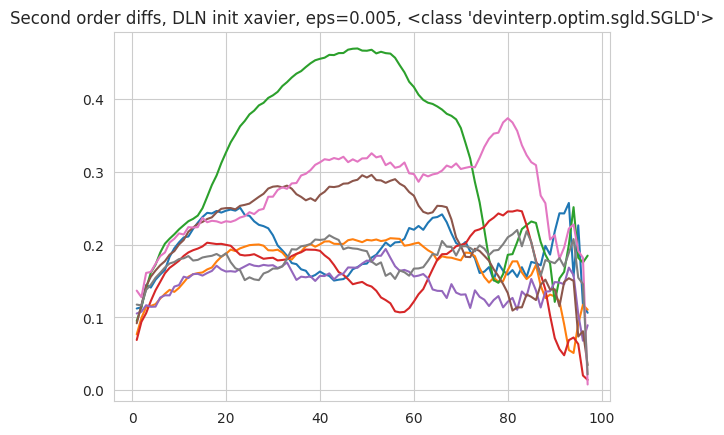

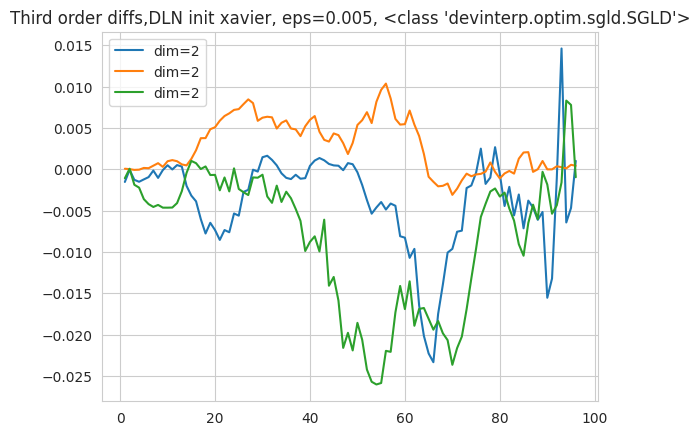

In [11]:
flattened = wt_sgld.reshape((num_chains_sgld, num_draws_sgld, -1))
print(flattened.shape)
plot_second_order_one_place_stats(
    flattened,
    1,
    title=f"Second order diffs, DLN init {method}, eps={epsilon_sgld}, {sampling_method}",
)
plot_third_order_stats_per_dim(
    flattened,
    1,
    title=f"Third order diffs,DLN init {method}, eps={epsilon_sgld}, {sampling_method}",
    up_to_dim=3,
)

# **SGHNT trajectories sampling**

In [12]:
sampling_method = SGNHT
num_chains_sgnht = 1
num_draws_sgnht = 10_0

epsilon_sgnht = 0.001

In [13]:
sgnht_weights = WeightCallback(
    num_chains=num_chains_sgnht, num_draws=num_draws_sgnht, model=model
)
online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgnht,
    num_draws=num_draws_sgnht,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)

trace_sgnht = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(
        lr=epsilon_sgnht, nbeta=nbeta, diffusion_factor=0.005, bounding_box_size=1.0
    ),
    sampling_method=sampling_method,
    num_chains=num_chains_sgnht,  # independent sampling runs
    num_draws=num_draws_sgnht,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, sgnht_weights],
    seed=SEED,
)

/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0:   0%|          | 0/100 [00:00<?, ?it/s]

Chain 0: 100%|██████████| 100/100 [00:00<00:00, 107.44it/s]


In [14]:
wt_sgnht = np.array(sgnht_weights.get_results()["ws/trace"])

print(np.nonzero(np.isnan(wt_sgnht)))
print(epsilon_sgld * num_draws_sgnht)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
0.5


## **Plot cumulant statistics of marginal distribution of jet coordinates SGNHT**

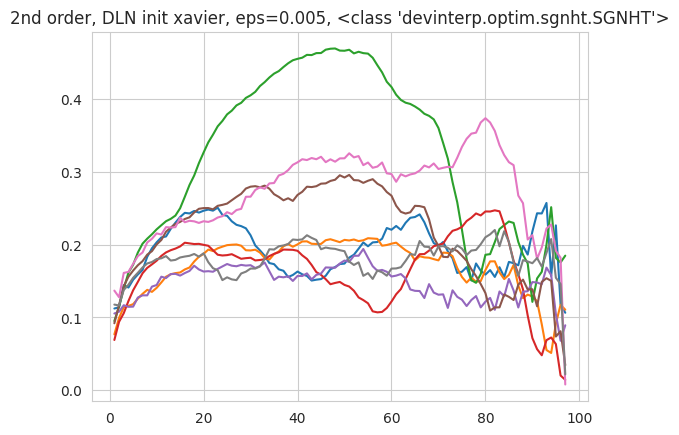

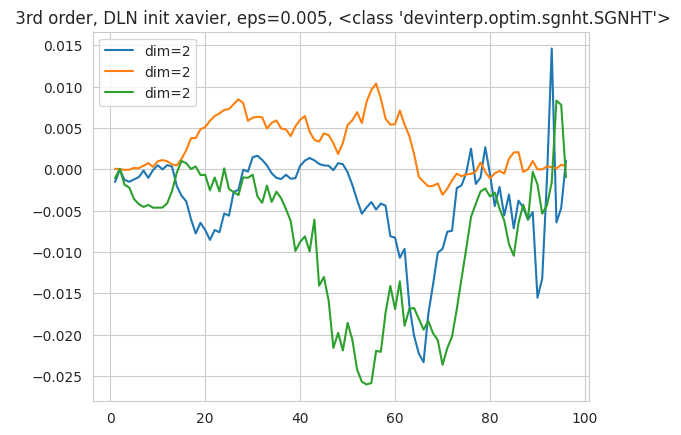

In [15]:
flattened = wt_sgld.reshape((num_chains_sgld, num_draws_sgld, -1))
plot_second_order_one_place_stats(
    flattened,
    1,
    title=f"2nd order, DLN init {method}, eps={epsilon_sgld}, {sampling_method}",
)
plot_third_order_stats_per_dim(
    flattened,
    1,
    title=f" 3rd order, DLN init {method}, eps={epsilon_sgld}, {sampling_method}",
    up_to_dim=4,
)